In [15]:
import os
print(os.getcwd())
import numpy as np
from pathlib import Path
import random
import time
import copy
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('PyTorch device:', device)

import multiprocessing as mp
print('cpu count:', mp.cpu_count())

/kaggle/working
PyTorch device: cuda
cpu count: 4


In [16]:
# fnidx.txt is preprocessed index file
fnidx = []
with open('../input/european-flood-2013/fnidx.txt') as f:
    while line:=f.readline().strip():
        if line == '':
            break
        fnidx.append(tuple(line.split()))
print(len(fnidx))

3710


In [17]:
# train depth
# find out all depth data
data = []
for f in fnidx:
    if int(f[1]) == 1:
        data.append((f[0],1))

size = len(data)
_t = copy.deepcopy(fnidx)
random.seed(7)
random.shuffle(fnidx)
i = -1
while size > 0:
    i += 1
    if int(fnidx[i][1]) != 1:
        data.append((fnidx[i][0],0))
        size -= 1

fnidx = _t
random.seed(8)
random.shuffle(data)
print(len(data))

3098


In [18]:
# split 20% for validation
sid = int(len(data)*0.8)
train, val = data[:sid], data[sid:]
print(len(train), sum([i for _,i in train]))
print(len(val))
batch_size = 256
#train = train[:batch_size*4]
#val = val[:batch_size]
print('batch size:', batch_size)
print(len(train))
print(len(val))


2478 1231
620
batch size: 256
2478
620


In [19]:
to_rgb = lambda x: x.convert('RGB')
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

transform_train = transforms.Compose([
    to_rgb,
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    #transforms.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.1,hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std),
])

transform_val = transforms.Compose([
    to_rgb,
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std),
])

In [20]:
from functools import lru_cache


class FloodDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    @lru_cache(maxsize=None)
    def _read_img(self, idx):
        return Image.open(self.data[idx][0])

    def __getitem__(self, idx):
        img = self.transform(self._read_img(idx))
        label = torch.tensor([self.data[idx][1]],dtype=torch.float32)
        return img, label


train_ds = FloodDataset(train, transform_train)
val_ds = FloodDataset(val, transform_val)

train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=3)
val_loader = DataLoader(val_ds,
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=True)

random batch: 1
Batch 1:
  Images shape: torch.Size([256, 3, 224, 224])
  Labels shape: torch.Size([256, 1])
  Images dtype: torch.float32
  Labels dtype: torch.float32
random index: [251, 33, 46, 221, 86, 179, 6, 245]


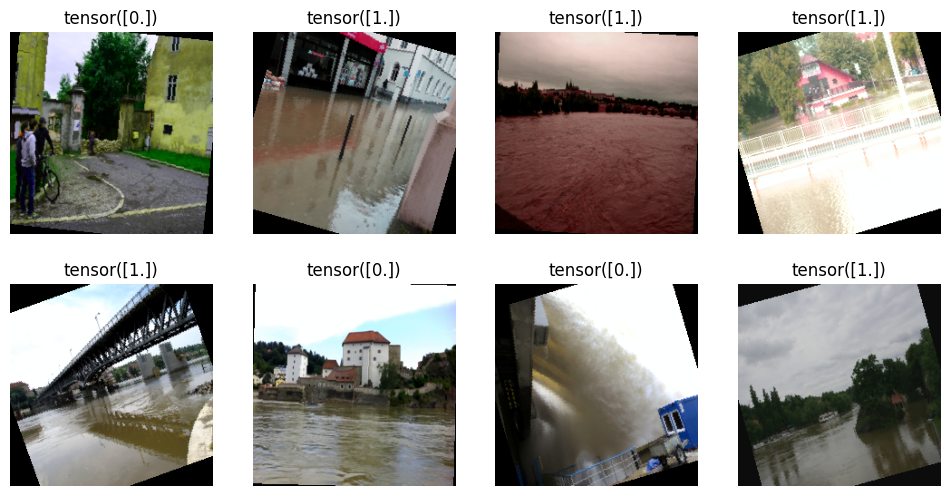

In [21]:
random.seed()
rbatch = random.randint(1,int(len(train_ds)/batch_size))
print('random batch:', rbatch)

for i, (images, labels) in enumerate(train_loader,1):
    if i != rbatch:
        continue
    print(f"Batch {i}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Images dtype: {images.dtype}")
    print(f"  Labels dtype: {labels.dtype}")
    # visually check normalized image
    images = images.numpy().transpose((0,2,3,1))
    ridx = random.sample(range(0,images.shape[0]), 8)
    print('random index:', ridx)
    fig, ax = plt.subplots(2,4,figsize=(12,6))
    for i in range(8):
        ax[i//4,i%4].imshow(images[i]*std+mean)
        ax[i//4,i%4].set_title(str(labels[i]))
        ax[i//4,i%4].axis('off')
    break

In [22]:
def collect_metrics(outputs, targets, threshold=0.5):
    predictions = (outputs > threshold).float()
    tp = (predictions * targets).sum(dim=0)
    fp = (predictions * (1-targets)).sum(dim=0)
    fn = ((1-predictions) * targets).sum(dim=0)
    return tp, fp, fn

def precisions(tp, fp, epsilon=1e-8):
    return tp / (tp+fp+epsilon)

def recalls(tp, fn, epsilon=1e-8):
    return tp / (tp+fn+epsilon)

def f1s(p, r, epsilon=1e-8):
    return (2*p*r) / (p+r+epsilon)

def save_checkpoint(model, n=36):
    """ save latest n checkpoint """
    ckpath = Path(os.getcwd())
    pathname = ckpath / f'mlvgg16.{str(model.epochs).rjust(3,"0")}.pth'
    torch.save(model, pathname)
    fnlist = sorted([f for f in ckpath.iterdir() if f.is_file() and f.name.endswith(".pth")])
    if len(fnlist) > n:
        for f in fnlist[:-n]:
            f.unlink()

In [23]:
class MultiLabelVGG16(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        #for param in self.vgg16.features.parameters():
        #    param.requires_grad = False
        for name, param in self.vgg16.features.named_parameters():
            if name[:2] in ('17','19','21','24','26','28'):
                param.requires_grad = True
            else:
                param.requires_grad = False
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, n_class),
            nn.Sigmoid()
        )
        self.epochs = 0

    def forward(self, x):
        return self.vgg16(x)

In [24]:
loss_data = [(0,0,0)]

In [25]:
load_model = False

if load_model:
    ckname = f'mlvgg16.{200}.pth'
    mlvgg16 = torch.load(ckname,weights_only=False)
else:
    mlvgg16 = MultiLabelVGG16(1)

print(mlvgg16)

MultiLabelVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [26]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlvgg16.parameters(),
                             lr=1e-5,
                             weight_decay=5e-6)
scheduler = StepLR(optimizer,
                   step_size=8,
                   gamma=0.5)

In [27]:
def _validate(model, val_loader, criterion, dev):
    model.eval()
    model.to(dev)
    running_loss = 0.0
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(dev)
            Y = Y.to(dev)
            outputs = model(X)
            loss = criterion(outputs, Y)
            running_loss += loss.item()   
    return running_loss


def train_val(model,
              train_loader,
              val_loader,
              criterion,
              optimizer,
              dev,
              epochs):
    """ train and validate """
    global loss_data
    for epoch in range(epochs):
        model.train()
        model.to(dev)
        running_loss = 0.0
        total_tp = 0
        total_fp = 0
        total_fn = 0
        tic = time.time()
        for X, Y in train_loader:
            X = X.to(dev)
            Y = Y.to(dev)
            optimizer.zero_grad()         
            outputs = model(X)
            loss = criterion(outputs, Y)  
            loss.backward()               
            optimizer.step()              
            running_loss += loss.item()   
            tp, fp, fn = collect_metrics(outputs.data, Y)
            total_tp += tp
            total_fp += fp
            total_fn += fn
        toc = time.time()
        model.epochs += 1
        scheduler.step()
        val_running_loss = _validate(model, val_loader, criterion, dev)
        if loss_data[-1][0] >= model.epochs:
            loss_data = loss_data[:model.epochs]
        loss_data.append((model.epochs,running_loss,val_running_loss))
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {model.epochs}, lr {current_lr}, '
              f'Loss(T): {round(running_loss,8)}, '
              f'Loss(V): {round(val_running_loss,8)}, '
              f'Time: {round(toc-tic,4)}s')
        prec = precisions(total_tp, total_fp)
        rec = recalls(total_tp, total_fn)
        print('  precision:', prec)
        print('  recall:   ', rec)
        print('  f1:       ', f1s(prec,rec))
        save_checkpoint(model)

In [28]:
train_val(mlvgg16, 
          train_loader,
          val_loader,
          criterion,
          optimizer,
          device,
          36)

Epoch 1, lr 1e-05, Loss(T): 6.96778464, Loss(V): 1.93406576, Time: 21.4778s
  precision: tensor([0.5217], device='cuda:0')
  recall:    tensor([0.5556], device='cuda:0')
  f1:        tensor([0.5382], device='cuda:0')
Epoch 2, lr 1e-05, Loss(T): 6.38148987, Loss(V): 1.81553614, Time: 21.0839s
  precision: tensor([0.6057], device='cuda:0')
  recall:    tensor([0.7425], device='cuda:0')
  f1:        tensor([0.6672], device='cuda:0')
Epoch 3, lr 1e-05, Loss(T): 6.0135709, Loss(V): 1.69604188, Time: 21.8976s
  precision: tensor([0.6664], device='cuda:0')
  recall:    tensor([0.7287], device='cuda:0')
  f1:        tensor([0.6962], device='cuda:0')
Epoch 4, lr 1e-05, Loss(T): 5.74309576, Loss(V): 1.62324589, Time: 21.5647s
  precision: tensor([0.6890], device='cuda:0')
  recall:    tensor([0.7506], device='cuda:0')
  f1:        tensor([0.7185], device='cuda:0')
Epoch 5, lr 1e-05, Loss(T): 5.52789068, Loss(V): 1.59031016, Time: 23.4073s
  precision: tensor([0.7085], device='cuda:0')
  recall: 

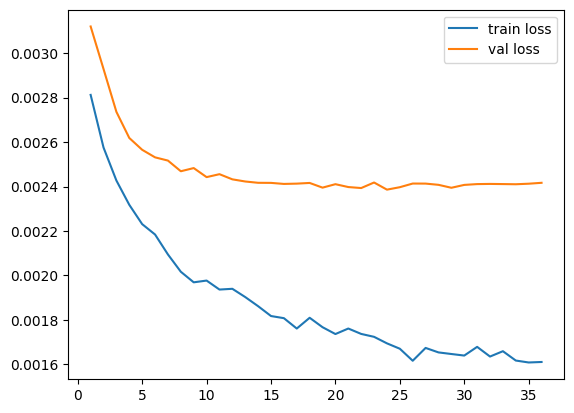

In [29]:
x = [i for i,_,_ in loss_data[1:]]
loss_train = [loss/len(train) for _,loss,_ in loss_data[1:]]
loss_val = [loss/len(val) for _,_,loss in loss_data[1:]]
plt.plot(x, loss_train, label='train loss')
plt.plot(x, loss_val, label='val loss')
plt.legend();